## Linear Regression

Linear regression models are a good starting point for regression tasks. Such models are popular becasue they can be fir very quickly, and are very  interpretable. You are probably familiar with the simplest form of a linear regression model but such models can be extended to model more complicated data behavior.

In this section we will start with a quick intuitive walk-through of the mathematics behind this well-known problem, before seeing how before moving on to see how linear models can be generalized to account for more complicated patterns in data.

We begin with the standard imports:

In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt 
import seaborn as sns; sns.set()
import numpy as np

## Simple Linear Regression

We will start with the most familiar linear regression, a straight-line fit to data. A straight-line fit is a model of the form

$$ y = ax + b $$

Where **a** is commonly known as the *slope*, and **b** is comonly known as the *intercept*

Consider the following data, which is scattered about a line with a slope of 2 and an intercept of -5:

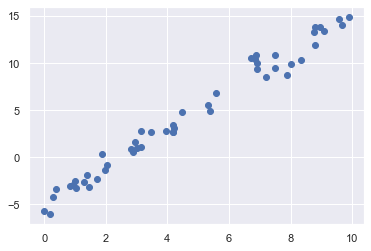

In [4]:
rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = 2 * x - 5 + rng.randn(50)
plt.scatter(x, y);

We an use Scikit-Learn's `LinearRegression` estimator to fit this data and construct the best-fit line:

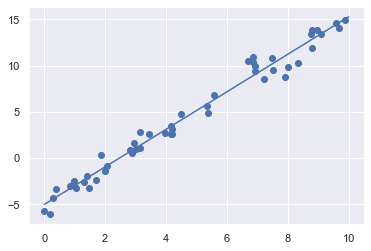

In [7]:
from sklearn.linear_model import LinearRegression

model = LinearRegression(fit_intercept=True)

model.fit(x[:, np.newaxis], y)
xfit = np.linspace(0, 10, 1000)
yfit = model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit);

The slope and intercept of the data are contained in the model's fit parameters, which in Scikit-Learn are always marked by a trailing underscore. Here the relevant parameters are `coef_` and `intercept_`:

In [9]:
print("Model slope  ", model.coef_[0])
print("Model intercept:", model.intercept_)

Model slope   2.0272088103606944
Model intercept: -4.9985770855532


We see that the results are very close to the inputs, as we might hope.

The `LinearRegression` estimator is much more capable than this, however--in addition to simple straight-line fits, it can also handle multidimensional linear models of the form

$$y=a_0 + a_{1}x_{1} + a_{2}x_{2} + ...$$

where there are multiple **x** values. Geometrically, this is akin to fitting a plane to points in three dimensions, or fitting a hyper-plane to poitns in higher dimensions.

The multidimensional nature of such regressions makes them more difficult to visualize, but we can see one of these fits in action by building some example data, using NumPy's matrix multiplication operator:

In [11]:
rng = np.random.RandomState(1)
X = 10 * rng.rand(100, 3)
y = 0.5 + np.dot(X, [1.5, -2., 1.])

Here the **y** data is constructed from the three random **x** values, and the linear regression recovers the coefficients used to construct the data. 

In this way, we can use the single `LinearRegression` estimator to fit lines, planes or hyperplanes to our data. It still appears that this approach would be limited to stricly linear relationships between variables, but it turns out we can relax this as well.